In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as T

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
c:\users\bhuey\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Bayesian robust correlation with PyMC3
Ported from Stan: https://baezortega.github.io/2018/05/28/robust-correlation/

In [2]:
def mad(data, axis=None):
    return np.median(np.absolute(data - np.median(data, axis)), axis)

def covariance(sigma, rho):
    C = T.alloc(rho, 2, 2)
    C = T.fill_diagonal(C, 1.)
    S = T.diag(sigma)
    return S.dot(C).dot(S)

def analyze_robust(data):
    with pm.Model() as model:
        # priors might be adapted here to be less flat
        mu = pm.Normal('mu', mu=0., sd=100., shape=2, testval=np.median(data.T, axis=1))
        bound_sigma = pm.Bound(pm.Normal, lower=0.)
        sigma = bound_sigma('sigma', mu=0., sd=100., shape=2, testval=mad(data, axis=0))
        rho = pm.Uniform('r', lower=-1., upper=1., testval=0)
        cov = pm.Deterministic('cov', covariance(sigma, rho))
        bound_nu = pm.Bound(pm.Gamma, lower=1.)
        nu = bound_nu('nu', alpha=2, beta=10)
        mult_t = pm.MvStudentT('mult_t', nu=nu, mu=mu, Sigma=cov, observed=data)
    return model

In [3]:
sigma = [20, 40]
r = -0.95
cov_mat = [sigma[0]**2, sigma[0] * sigma[1] * r, sigma[0] * sigma[1] * r, sigma[1]**2]
cov_mat = np.array(cov_mat).reshape((2,2))

x_clean = np.random.multivariate_normal([0,0], cov_mat, size=40)
np.corrcoef(x_clean.T)

array([[ 1.       , -0.9429512],
       [-0.9429512,  1.       ]])

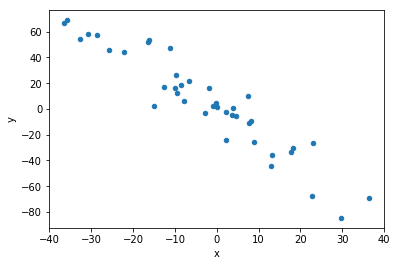

In [4]:
pd.DataFrame(x_clean, columns=['x', 'y']).plot(x='x', y='y', kind='scatter')

In [7]:
x_noisy = x_clean
x_noisy[0:3,:] = np.array([-40, -60, 20, 100, 40, 40]).reshape(3,2)
np.corrcoef(x_noisy.T)

array([[ 1.        , -0.53149904],
       [-0.53149904,  1.        ]])

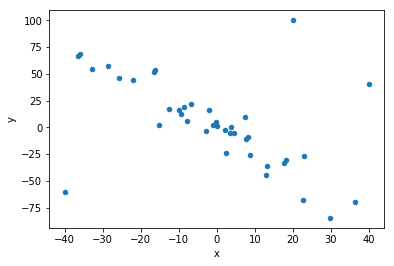

In [19]:
pd.DataFrame(x_noisy, columns=['x', 'y']).plot(x='x', y='y', kind='scatter')

In [21]:
clean_model = analyze_robust(x_clean)
with clean_model:
    clean_trace = pm.sample(2000, tune=500, step=pm.NUTS(), chains=1, init='nuts')

Sequential sampling (1 chains in 1 job)
NUTS: [nu, r, sigma, mu]
100%|██████████| 2500/2500 [00:26<00:00, 93.82it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001C7E4588>,
      dtype=object)

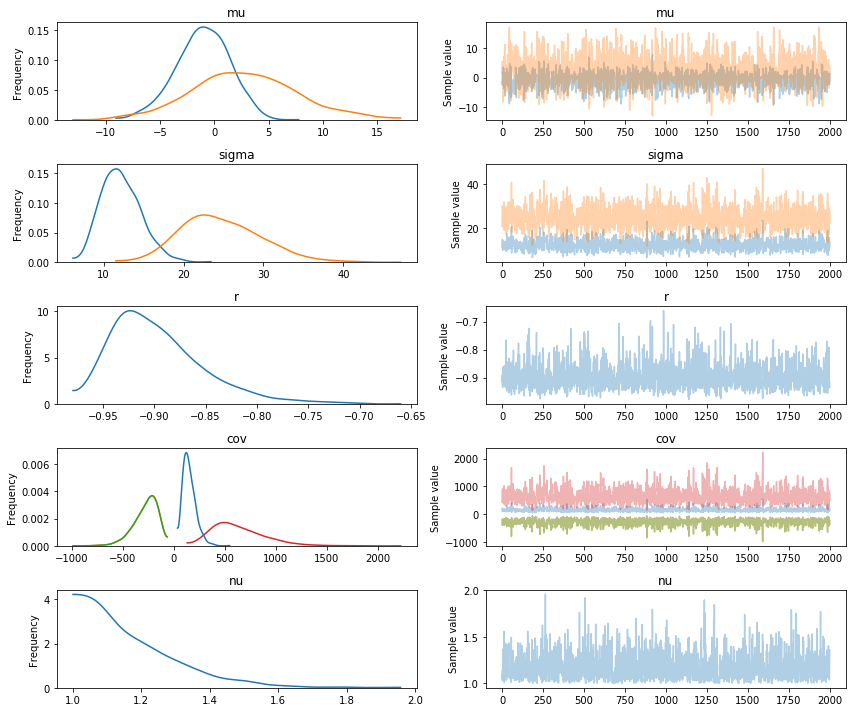

In [22]:
pm.traceplot(clean_trace)

In [24]:
np.median(clean_trace['r'])

-0.9049709880450097

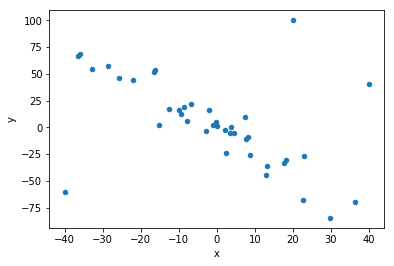

In [6]:
pd.DataFrame(x_noisy, columns=['x', 'y']).plot(x='x', y='y', kind='scatter')

In [14]:
noisy_model = analyze_robust(x_noisy)
with noisy_model:
    noisy_trace = pm.sample(2000, tune=500, step=pm.NUTS(), chains=1, init='nuts')

Sequential sampling (1 chains in 1 job)
NUTS: [nu, r, sigma, mu]
100%|██████████| 2500/2500 [00:25<00:00, 96.22it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001D42D1D0>,
      dtype=object)

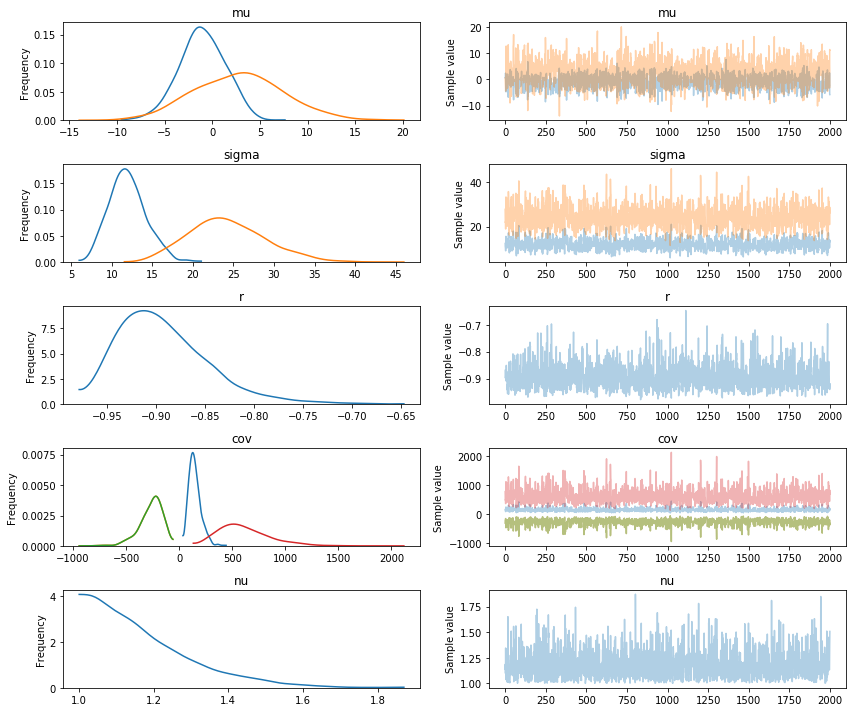

In [15]:
pm.traceplot(noisy_trace)

In [18]:
np.mean(noisy_trace['r'])

-0.8997704508755462